## Importing packages ##

In [ ]:
import xgboost 
import pandas as pd 
import numpy as np
from sklearn.model_selection import train_test_split # split data into two sets (train and test)
from sklearn.model_selection import GridSearchCV 
from sklearn.metrics import balanced_accuracy_score , roc_auc_score , make_scorer # ROC
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix # confusion matrix
from sklearn.metrics import plot_confusion_matrix # the drawing of confusion matrix
from sklearn.metrics import accuracy_score # accuracy score

## Importing Data ##

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df=pd.read_csv('/content/drive/MyDrive/Data_set/final_dataset_smes.csv') 
df.drop('Unnamed: 0',axis=1, inplace=True)
df
df["status"].value_counts()

0    13413
1     1632
Name: status, dtype: int64

## Splitting data into two (Train and Test) ##

In [ ]:
var_columns = [c for c in df.columns if c !='status']
X= df.loc[:, var_columns] # the variables that we're gonna use to build our model
y= df.loc[:, 'status'] # the result we wanna acheive

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2) #"test_size=0.2"=>the proportion of the dataset to include in the test split X/y_valid (test 20% train 80%)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((12036, 24), (3009, 24), (12036,), (3009,))

## XGBoost Model ##
We will now create the XGBoost Model

In [ ]:
model_xgboost = xgboost.XGBClassifier() # without hyper parameters 
eval_set = [(X_test, y_test)] # the evaluation data set while the model is being trained
model_xgboost.fit(X_train,
                  y_train,
                  early_stopping_rounds=10,#if the model doesn't change on the validation dataset for 10 iteration then the training will stop 
                  eval_set=eval_set,
                  verbose=True)

[0]	validation_0-error:0.084746
Will train until validation_0-error hasn't improved in 10 rounds.
[1]	validation_0-error:0.083416
[2]	validation_0-error:0.082752
[3]	validation_0-error:0.081422
[4]	validation_0-error:0.081755
[5]	validation_0-error:0.082087
[6]	validation_0-error:0.082087
[7]	validation_0-error:0.080758
[8]	validation_0-error:0.081422
[9]	validation_0-error:0.082087
[10]	validation_0-error:0.081422
[11]	validation_0-error:0.081422
[12]	validation_0-error:0.081422
[13]	validation_0-error:0.080758
[14]	validation_0-error:0.080758
[15]	validation_0-error:0.08109
[16]	validation_0-error:0.080758
[17]	validation_0-error:0.080425
[18]	validation_0-error:0.080093
[19]	validation_0-error:0.079428
[20]	validation_0-error:0.080093
[21]	validation_0-error:0.079428
[22]	validation_0-error:0.079096
[23]	validation_0-error:0.079096
[24]	validation_0-error:0.079428
[25]	validation_0-error:0.080093
[26]	validation_0-error:0.08109
[27]	validation_0-error:0.080758
[28]	validation_0-erro

XGBClassifier()

Now we will evaluate the model using the auc



In [ ]:
#to evaluate our model we will use "predict_proba()" function 
#this function has two output one is the prob that we have a "0" and the second that we have a "1" as a result
y_train_pred = model_xgboost.predict_proba(X_train)[:,1]
y_test_pred = model_xgboost.predict_proba(X_test)[:,1]

#"roc_auc_score" function will give us the area under curve metric 
print("AUC Train: {:.4f}\nAUC Test: {:.4f}".format(roc_auc_score(y_train, y_train_pred),
                                                    roc_auc_score(y_test, y_test_pred)))
print(y_test_pred) 

AUC Train: 0.8607
AUC Test: 0.8564
[0.1036206  0.7988956  0.07356198 ... 0.3548842  0.17921285 0.10035802]


Now we will evaluate the model using the accuracy score

In [ ]:

for i in range(0, X_test.shape[0]): 
    if y_test_pred[i]>=.5:       # setting threshold to .5 
       y_test_pred[i]=1 
    else: 
       y_test_pred[i]=0  

print('the accuracy of XGBoost is',accuracy_score(y_test_pred, y_test))    

the accuracy of XGBoost is 0.9209039548022598


Now we will draw the confusion matrix for our first model 

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


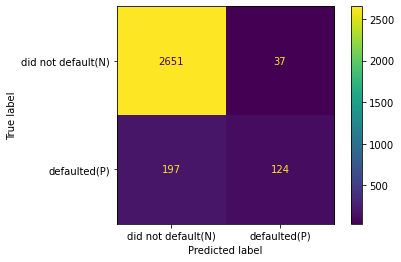

In [ ]:
plot_confusion_matrix(model_xgboost,# our model
                      X_test,# test data set
                      y_test,
                     display_labels=["did not default(N)","defaulted(P)"])#set labels 

here we are able to classify our results from the confusion matrix into 4 classes:\
-TP(TruePositives) : "2623" => companies predicted to default, which do\
-FP(FalsePositive) : "41"  => companies predicted to default, that do not\
-TN(True Negative) : "211"  => companies predicted not to default, which do not\
-FN(False Negative) : "134" => companies predicted not to default, which do

## Improoving the model ##
we can see the created model is not bad for beginnig but we can try improving it with changing the hyper params of XGBoost's model \
let's see what we can do


we will now try to find the best combination of hyper params to have the best model for us 

In [ ]:
learning_rate_list = [0.02, 0.05, 0.1] #Step size shrinkage used in update to prevents overfitting
max_depth_list = [2, 3, 5]#Maximum depth of a tree
n_estimators_list = [100, 200, 300]#Maximum number of trees will be created

#we must store them in a dict because GridSearchCV only accept dict
params_dict = {"learning_rate": learning_rate_list,
               "max_depth": max_depth_list,
               "n_estimators": n_estimators_list}

num_combinations = 1
for v in params_dict.values(): num_combinations *= len(v) # number of all combination that we can have 

print(' number of all possible combinations is : '+ str(num_combinations))
params_dict

 number of all possible combinations is : 27


{'learning_rate': [0.02, 0.05, 0.1],
 'max_depth': [2, 3, 5],
 'n_estimators': [100, 200, 300]}

In [ ]:
#"roc_auc_score(...)" is a function in which it calculates the area under curve auc we will use it to have the best model between 27 of them
def my_roc_auc_score(model, X, y): return roc_auc_score(y, model.predict_proba(X)[:,1])

model_xgboost_hp = GridSearchCV(estimator=xgboost.XGBClassifier(subsample=0.5, # this is an estimator for GridSearchCV in which contains the usual params of XGBoost
                                                                colsample_bytree=0.25,#the number of columns to be randomly samples for each tree.
                                                                eval_metric='auc', #The metric to be used for validation data , we will use "auc": Area under the curve
                                                                use_label_encoder=False),
                                param_grid=params_dict, # the params that will be changed each time
                                cv=2, #the data will be splited in two parts one for the validation and the other for training for the first part but vice-versa in the second part(generally the value of this is 3 or 4) 
                                scoring=my_roc_auc_score, # this is a special method done by us because the input is not suitable for the roc_auc_score (it evaluates or model)
                                return_train_score=True,#shows the training score
                                verbose=4)#logs

model_xgboost_hp.fit(X, y)

Fitting 2 folds for each of 27 candidates, totalling 54 fits
[CV 1/2] END learning_rate=0.02, max_depth=2, n_estimators=100;, score=(train=0.831, test=0.873) total time=   0.5s
[CV 2/2] END learning_rate=0.02, max_depth=2, n_estimators=100;, score=(train=0.892, test=0.827) total time=   0.4s
[CV 1/2] END learning_rate=0.02, max_depth=2, n_estimators=200;, score=(train=0.845, test=0.884) total time=   0.9s
[CV 2/2] END learning_rate=0.02, max_depth=2, n_estimators=200;, score=(train=0.908, test=0.832) total time=   0.9s
[CV 1/2] END learning_rate=0.02, max_depth=2, n_estimators=300;, score=(train=0.859, test=0.890) total time=   2.3s
[CV 2/2] END learning_rate=0.02, max_depth=2, n_estimators=300;, score=(train=0.918, test=0.833) total time=   2.1s
[CV 1/2] END learning_rate=0.02, max_depth=3, n_estimators=100;, score=(train=0.844, test=0.879) total time=   0.9s
[CV 2/2] END learning_rate=0.02, max_depth=3, n_estimators=100;, score=(train=0.906, test=0.832) total time=   0.8s
[CV 1/2] EN

GridSearchCV(cv=2,
             estimator=XGBClassifier(colsample_bytree=0.25, eval_metric='auc',
                                     subsample=0.5, use_label_encoder=False),
             param_grid={'learning_rate': [0.02, 0.05, 0.1],
                         'max_depth': [2, 3, 5],
                         'n_estimators': [100, 200, 300]},
             return_train_score=True,
             scoring=<function my_roc_auc_score at 0x7f24cf8f5680>, verbose=4)

after generating 27 XGBoost models we need now to identify the best one of them by ranking by the auc 

In [ ]:
df_cv_results = pd.DataFrame(model_xgboost_hp.cv_results_) #framing the obtained GridSearchCV result 
df_cv_results = df_cv_results[['rank_test_score','mean_test_score','mean_train_score',
                               'param_learning_rate', 'param_max_depth', 'param_n_estimators']]
df_cv_results.sort_values(by='rank_test_score', inplace=True)#sort the result by "rank_test_score"
df_cv_results
#we can see the best set of parmas for us is: 
#- param_learning_rate=0.1
#- param_max_depth=3
#- param_n_estimators=100

,rank_test_score,mean_test_score,mean_train_score,param_learning_rate,param_max_depth,param_n_estimators
21,1,0.867375,0.923363,0.1,3,100
8,2,0.866755,0.947308,0.02,5,300
22,3,0.866529,0.947673,0.1,3,200
13,4,0.866314,0.923843,0.05,3,200
5,5,0.866023,0.907339,0.02,3,300
14,6,0.865868,0.937060,0.05,3,300
16,7,0.865167,0.969899,0.05,5,200
10,8,0.864526,0.901265,0.05,2,200
7,9,0.864517,0.928897,0.02,5,200
19,10,0.864385,0.919362,0.1,2,200


now we will try the best XGB model 

In [ ]:
#know we will put the best combination of params in the XGBoost training model
model_xgboost_fin = xgboost.XGBClassifier(learning_rate=0.1,
                                          max_depth=3,
                                          n_estimators=100,
                                          subsample=0.5,
                                          colsample_bytree=0.25,
                                          eval_metric='auc',
                                          verbosity=1,
                                          use_label_encoder=False)

# Passing both training and validation dataset as we want to plot AUC for both
eval_set = [(X_train, y_train),(X_test, y_test)]

model_xgboost_fin.fit(X_train,
                  y_train,
                  early_stopping_rounds=20,
                  eval_set=eval_set,
                  verbose=True)

[0]	validation_0-auc:0.765697	validation_1-auc:0.779799
Multiple eval metrics have been passed: 'validation_1-auc' will be used for early stopping.

Will train until validation_1-auc hasn't improved in 20 rounds.
[1]	validation_0-auc:0.81079	validation_1-auc:0.835909
[2]	validation_0-auc:0.820454	validation_1-auc:0.843155
[3]	validation_0-auc:0.823432	validation_1-auc:0.846652
[4]	validation_0-auc:0.827951	validation_1-auc:0.849715
[5]	validation_0-auc:0.829119	validation_1-auc:0.851681
[6]	validation_0-auc:0.830511	validation_1-auc:0.852529
[7]	validation_0-auc:0.830888	validation_1-auc:0.852537
[8]	validation_0-auc:0.835045	validation_1-auc:0.857184
[9]	validation_0-auc:0.837922	validation_1-auc:0.85722
[10]	validation_0-auc:0.841244	validation_1-auc:0.855834
[11]	validation_0-auc:0.841295	validation_1-auc:0.8581
[12]	validation_0-auc:0.843819	validation_1-auc:0.86066
[13]	validation_0-auc:0.846117	validation_1-auc:0.85991
[14]	validation_0-auc:0.846961	validation_1-auc:0.861738
[15]

XGBClassifier(colsample_bytree=0.25, eval_metric='auc', subsample=0.5,
              use_label_encoder=False)

In [ ]:
#now we will evaluate our model using AUC
y_train_pred = model_xgboost_fin.predict_proba(X_train)[:,1]
y_valid_pred = model_xgboost_fin.predict_proba(X_test)[:,1]

print("AUC Train: {:.4f}\nAUC Valid: {:.4f}".format(roc_auc_score(y_train, y_train_pred),
                                                    roc_auc_score(y_test, y_valid_pred)))

AUC Train: 0.9004
AUC Valid: 0.8781


In [ ]:
#Now we will evaluate the model using the accuracy score
for i in range(0, X_test.shape[0]): 
    if y_valid_pred[i]>=.5:       # setting threshold to .5 
       y_valid_pred[i]=1 
    else: 
       y_valid_pred[i]=0  

print('the accuracy is',accuracy_score(y_valid_pred, y_test))    

the accuracy is 0.9205716184778996


## we can see a little improvement ##

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


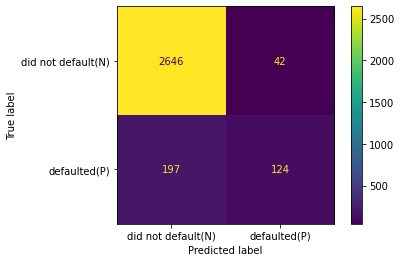

In [ ]:
plot_confusion_matrix(model_xgboost_fin,# our model
                      X_test,# test data set
                      y_test,
                     display_labels=["did not default(N)","defaulted(P)"])#set labels 